In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sentiment-analysis-on-movie-reviews/sampleSubmission.csv
/kaggle/input/sentiment-analysis-on-movie-reviews/train.tsv.zip
/kaggle/input/sentiment-analysis-on-movie-reviews/test.tsv.zip


## Sentiment Analysis of Movie Reviews
We want to use [Movie Reviews](https://www.kaggle.com/competitions/sentiment-analysis-on-movie-reviews) as our dataset for our Model

## Read dataset file

In [2]:
train_df = pd.read_csv('/kaggle/input/sentiment-analysis-on-movie-reviews/train.tsv.zip',sep='\t')

## Exploratory data

In [3]:
train_df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


as you see we have a duplicate rows

### Remove duplicate rows

In [4]:
train_df.drop_duplicates(subset=["SentenceId"], keep="first")

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
63,64,2,"This quiet , introspective and entertaining in...",4
81,82,3,"Even fans of Ismail Merchant 's work , I suspe...",1
116,117,4,A positively thrilling combination of ethnogra...,3
156,157,5,Aggressive self-glorification and a manipulati...,1
...,...,...,...,...
155984,155985,8540,... either you 're willing to go with this cla...,2
155997,155998,8541,"Despite these annoyances , the capable Claybur...",2
156021,156022,8542,-LRB- Tries -RRB- to parody a genre that 's al...,1
156031,156032,8543,The movie 's downfall is to substitute plot fo...,1


<AxesSubplot:>

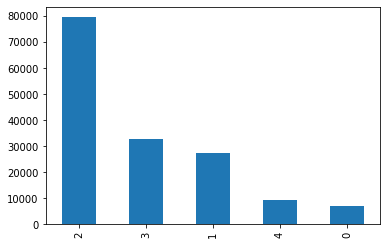

In [5]:
train_df["Sentiment"].value_counts().plot(kind="bar")

The sentiment labels are:

* 0-negative
* 1-somewhat negative
* 2-neutral
* 3-somewhat positive
* 4-positive

In [6]:
seq_len = 512
num_samples = len(train_df)
num_samples

156060

In [7]:
from transformers import BertTokenizer

## Use Bert tokenizer

In [8]:
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [9]:
# seq_len = 512
# num_samples = len(train_df)

tokens = tokenizer(train_df["Phrase"].tolist(),
                  max_length=seq_len,
                  truncation=True,
                  padding="max_length",
                  add_special_tokens=True, # the sequences will be encoded with the special tokens relative to their model
                  return_tensors="np")

In [10]:
tokens.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [11]:
tokens["input_ids"],tokens["attention_mask"]

(array([[  101,   138,  1326, ...,     0,     0,     0],
        [  101,   138,  1326, ...,     0,     0,     0],
        [  101,   138,  1326, ...,     0,     0,     0],
        ...,
        [  101,   170, 25247, ...,     0,     0,     0],
        [  101,   170, 25247, ...,     0,     0,     0],
        [  101, 22572, 12148, ...,     0,     0,     0]]),
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]))

zeros at the end of seq is related to padding

In [12]:
classes_arr = train_df["Sentiment"].values
classes_arr

array([1, 2, 2, ..., 3, 2, 2])

In [13]:
labels = np.zeros((num_samples, classes_arr.max()+1))
labels.shape

(156060, 5)

our dataframe has 5 class labels = {0 1 2 3 4}

### make one hot labels

In [14]:
labels[np.arange(num_samples), classes_arr] = 1
labels

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

"classes_arr" refer to which column must be 1

## Building a Dataset

[You can see this document if you are not fimiliar with Tensorflow dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)

In [15]:
import tensorflow as tf

In [16]:
dataset = tf.data.Dataset.from_tensor_slices((tokens["input_ids"],tokens["attention_mask"],labels))

In [17]:
dataset.take(1)

<TakeDataset shapes: ((512,), (512,), (5,)), types: (tf.int64, tf.int64, tf.float64)>

In [18]:
def map_func(input_ids, masks, labels):
    # we convert our three-item tuple into a two-item tuple where the input item is a dictionary
    return {'input_ids': input_ids, 'attention_mask': masks}, labels

# then we use the dataset map method to apply this transformation
dataset = dataset.map(map_func)

dataset.take(1)

<TakeDataset shapes: ({input_ids: (512,), attention_mask: (512,)}, (5,)), types: ({input_ids: tf.int64, attention_mask: tf.int64}, tf.float64)>

## Suffle data

In [19]:
batch_size = 16
dataset = dataset.shuffle(10000).batch(batch_size, drop_remainder=True)

In [20]:
dataset.take(1)

<TakeDataset shapes: ({input_ids: (16, 512), attention_mask: (16, 512)}, (16, 5)), types: ({input_ids: tf.int64, attention_mask: tf.int64}, tf.float64)>

In [21]:
split = 0.9
size = int(( tokens["input_ids"].shape[0] / batch_size) * split)
size

8778

## Split data to train and validation

In [22]:
train_ds = dataset.take(size)
val_ds = dataset.skip(size)

In [23]:
train_ds.take(1)

<TakeDataset shapes: ({input_ids: (16, 512), attention_mask: (16, 512)}, (16, 5)), types: ({input_ids: tf.int64, attention_mask: tf.int64}, tf.float64)>

## Now we want to use pretrained bert model

In [24]:
from transformers import TFAutoModel

In [25]:
bert = TFAutoModel.from_pretrained("bert-base-cased")

Downloading:   0%|          | 0.00/502M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [26]:
bert.summary()

Model: "tf_bert_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  108310272 
Total params: 108,310,272
Trainable params: 108,310,272
Non-trainable params: 0
_________________________________________________________________


In [27]:
input_ids = tf.keras.layers.Input(shape=(512,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(512,), name='attention_mask', dtype='int32')

# we access the transformer model within our bert object using the bert attribute (eg bert.bert instead of bert)
embeddings = bert.bert(input_ids, attention_mask=mask)[1]  # access final activations (alread max-pooled) [1]
# convert bert embeddings into 5 output classes
x = tf.keras.layers.Dense(1024, activation='relu')(embeddings)
y = tf.keras.layers.Dense(5, activation='softmax', name='outputs')(x)

In [28]:
# initialize model
model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

# freeze bert layer
model.layers[2].trainable = False

# print out model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 512)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
bert (TFBertMainLayer)          TFBaseModelOutputWit 108310272   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
dense (Dense)                   (None, 1024)         787456      bert[0][1]                   

In [29]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-6)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

In [30]:
history = model.fit(train_ds, validation_data=val_ds, epochs=1)

8778/8778 [==============================] - 6890s 784ms/step - loss: 1.1596 - accuracy: 0.5374 - val_loss: 1.1306 - val_accuracy: 0.5594


For saving the time I use just one epoch

In [31]:
def prep_data(text):
    tokens = tokenizer.encode_plus(text, max_length=512,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True, 
                                   return_token_type_ids=False,
                                   return_tensors='tf')
    # tokenizer returns int32 tensors, we need to return float64, so we use tf.cast
    return {'input_ids': tf.cast(tokens['input_ids'], tf.float64),
            'attention_mask': tf.cast(tokens['attention_mask'], tf.float64)}

## first prepare data and then sent to our model

In [32]:
probs = model.predict(prep_data("hello world"))[0]
probs

array([0.03586907, 0.15892401, 0.5331462 , 0.23018554, 0.04187513],
      dtype=float32)

In [33]:
np.argmax(probs)

2

So we have made a test prediction, but we want to be applying this to real phrases from test.tsv. We will load the data into a dataframe, remove fragment duplicates based on SentenceId

In [34]:
pd.set_option('display.max_colwidth', None)
tdf = pd.read_csv('/kaggle/input/sentiment-analysis-on-movie-reviews/test.tsv.zip',sep='\t')
tdf.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine effort .
1,156062,8545,An intermittently pleasing but mostly routine effort
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [35]:
tdf = tdf.drop_duplicates(subset=['SentenceId'], keep='first')
tdf.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine effort .
15,156076,8546,"Kidman is really the only thing that 's worth watching in Birthday Girl , a film by the stage-trained Jez Butterworth -LRB- Mojo -RRB- that serves as yet another example of the sad decline of British comedies in the post-Full Monty world ."
93,156154,8547,Once you get into its rhythm ... the movie becomes a heady experience .
117,156178,8548,I kept wishing I was watching a documentary about the wartime Navajos and what they accomplished instead of all this specious Hollywood hoo-ha .
158,156219,8549,"Kinnear does n't aim for our sympathy , but rather delivers a performance of striking skill and depth ."


Now we initialize our new sentiment column, and begin making predictions

In [36]:
tdf['Sentiment'] = None

for i, row in tdf.iterrows():
    # get token tensors
    tokens = prep_data(row['Phrase'])
    # get probabilities
    probs = model.predict(tokens)
    # find argmax for winning class
    pred = np.argmax(probs)
    # add to dataframe
    tdf.at[i, 'Sentiment'] = pred

tdf.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,156061,8545,An intermittently pleasing but mostly routine effort .,2
15,156076,8546,"Kidman is really the only thing that 's worth watching in Birthday Girl , a film by the stage-trained Jez Butterworth -LRB- Mojo -RRB- that serves as yet another example of the sad decline of British comedies in the post-Full Monty world .",3
93,156154,8547,Once you get into its rhythm ... the movie becomes a heady experience .,3
117,156178,8548,I kept wishing I was watching a documentary about the wartime Navajos and what they accomplished instead of all this specious Hollywood hoo-ha .,1
158,156219,8549,"Kinnear does n't aim for our sympathy , but rather delivers a performance of striking skill and depth .",3
